<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal Retrieval using GPT text embedding and CLIP image embedding

In this notebook, we show how to build a Multi-Modal retrieval system using LlamaIndex.

Text embedding index: Generate GPT text embeddings from OpenAI for texts

Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Query encoder:
* Encoder query text for text index using GPT embedding
* Encoder query text for image index using CLIP embedding

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Download texts and images raw files
2. Build text index for vector store using GPT embeddings
3. Build image index for vector store using CLIP embeddings
4. Retrieve relevant text and image simultaneously using different query encoding embeddings and vector stores

In [17]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
sh

## Load and Download Multi-Modal datasets including texts and images
Parse wikipedia articles and save into local folder

In [18]:
import os

os.environ["OPENAI_API_KEY"] = 'OPEN_API_KEY'

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
path = '/content/drive/MyDrive/GPT4_Vision_Product_Tagging/FashionImages'
os.chdir(path)

In [21]:
!pip install snowflake-connector-python

### Fetching Text Tags from SnowFlake Database

In [22]:
import snowflake.connector

# Snowflake connection parameters
snowflake_user = 'SNOWFLAKE_USER'
snowflake_password = 'SNOWFLAKE_PASSWORD'
snowflake_account = 'ACCOUNT_IDENTIFIER'
snowflake_database = 'DATABASE'
snowflake_schema = 'public'

# Snowflake connection
conn = snowflake.connector.connect(
    user=snowflake_user,
    password=snowflake_password,
    account=snowflake_account,
    database=snowflake_database,
    schema=snowflake_schema
)

# Create a cursor object
cursor = conn.cursor()

# Execute a query to fetch unique description tags
query = "SELECT DISTINCT description_tags FROM product_tags"
cursor.execute(query)

# Fetch the results
unique_tags_result = cursor.fetchall()

# Extract unique tags from the result
unique_tags = [tag[0] for tag in unique_tags_result]
print(unique_tags)

# Close the cursor
cursor.close()

# Close the connection
conn.close()

# Write unique tags into a text file
with open('unique_tags.txt', 'w') as file:
    for tag in unique_tags:
        file.write(f"{tag}\n")

print("Unique tags have been written to unique_tags.txt")


["men's clothing, chinos, slim fit, casual wear, semi-formal, solid color, black trousers, zip fly, belt loops, side pockets, back pockets, cotton blend, machine washable, button closure", "men's fashion, slim fit chinos, black trousers, zip fly, button closure, belt loops, side pockets, back pockets, cotton blend, casual wear, formal wear, solid color, versatile clothing, machine washable, office attire", "men's clothing, slim fit chinos, casual wear, solid color, button closure, zip fly, belt loops, back pockets, side pockets, cotton blend, machine washable, semi-formal, tapered leg, comfortable fit, versatile styling", "navy denim jacket, red plaid shirt, olive chinos, tan lace-up boots, men's fashion, casual style, fall attire, smart-casual dress, layered outfit, streetwear", "men's clothing, short-sleeve shirt, floral print, casual wear, summer shirt, button-up shirt, collared shirt, patterned shirt, fashion", "short sleeve shirt, floral print, casual wear, button-up, collared shi

In [23]:
from pathlib import Path
import shutil

image_path = '/content/drive/MyDrive/GPT4_Vision_Product_Tagging/FashionImages'
image_uuid = 0
image_metadata_dict = {}
MAX_IMAGES = 10

titles_file_path = 'unique_tags.txt'
try:
    with open(titles_file_path, 'r') as titles_file:
        titles = titles_file.read().splitlines()
except FileNotFoundError:
    print(f"Error: Titles file not found at {titles_file_path}")
    titles = []

for title in titles:
    images = 0
    print(title)

    try:
        image_folder_path = Path(image_path)

        for image_file_path in image_folder_path.glob('*.jpg'):
            image_uuid += 1
            image_file_name = title + "_" + image_file_path.name

            image_metadata_dict[image_uuid] = {
                "filename": image_file_name,
                "img_path": str(image_file_path),
            }

            images += 1

            if images > MAX_IMAGES:
                break
    except Exception as e:
        print(f"No images found for Wikipedia page: {title}, Error: {str(e)}")
        continue


men's clothing, chinos, slim fit, casual wear, semi-formal, solid color, black trousers, zip fly, belt loops, side pockets, back pockets, cotton blend, machine washable, button closure
men's fashion, slim fit chinos, black trousers, zip fly, button closure, belt loops, side pockets, back pockets, cotton blend, casual wear, formal wear, solid color, versatile clothing, machine washable, office attire
men's clothing, slim fit chinos, casual wear, solid color, button closure, zip fly, belt loops, back pockets, side pockets, cotton blend, machine washable, semi-formal, tapered leg, comfortable fit, versatile styling
navy denim jacket, red plaid shirt, olive chinos, tan lace-up boots, men's fashion, casual style, fall attire, smart-casual dress, layered outfit, streetwear
men's clothing, short-sleeve shirt, floral print, casual wear, summer shirt, button-up shirt, collared shirt, patterned shirt, fashion
short sleeve shirt, floral print, casual wear, button-up, collared shirt, summer fashio

## Build Multi Modal Vector Store using Text and Image embeddings under different collections

In [24]:
import qdrant_client
from llama_index import (
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index import VectorStoreIndex, StorageContext
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_db_new")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(vector_store=text_store)

# Create the MultiModal index
documents = SimpleDirectoryReader("/content/drive/MyDrive/GPT4_Vision_Product_Tagging/FashionImages/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents, storage_context=storage_context, image_vector_store=image_store
)

### Plot downloaded Images

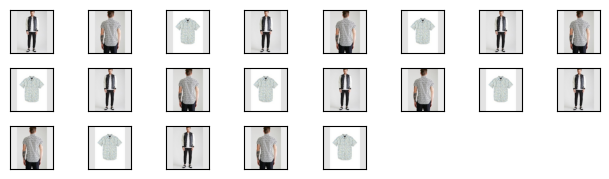

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
import os
from pathlib import Path

def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0

    # Create a Path object for the image folder
    image_folder_path = Path(image_path)

    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]

        # Use Path to check if the file exists
        if Path(img_path).is_file():
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()

# Call the function with the modified image metadata
plot_images(image_metadata_dict)

### Build a separate CLIP image embedding index under a differnt collection

In [26]:
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

### Get Multi-Modal retrieval results for some example queries

In [35]:
test_query = "give me white shirt"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=1, image_similarity_top_k=1)
retrieval_results = retriever.retrieve(test_query)

**Node ID:** 35b94e02-0bf8-4369-94db-640a32a4c62c<br>**Similarity:** 0.7393200179996271<br>**Text:** men's clothing, chinos, slim fit, casual wear, semi-formal, solid color, black trousers, zip fly, belt loops, side pockets, back pockets, cotton blend, machine washable, button closure
men's fashio...<br>

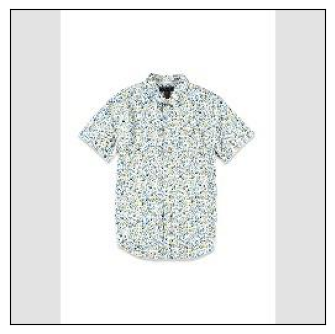

In [36]:
from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)